In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
os.environ["THEANO_FLAGS"] = "device=gpu"
sys.path.append(os.getcwd()+"/..")
from tasks import check

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using gpu device 0: Tesla K20Xm (CNMeM is disabled, CuDNN 3007)
/home/mcherti/work/code/scikit-learn/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.19.
  "This module will be removed in 0.19.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from model import model60

In [3]:
all_layers = model60(nb_filters=64, w=96, h=96, c=3, nb_layers=10, block_size=3)

In [4]:
import theano.tensor as T
import theano
from lasagne import layers

X = T.tensor4()
Y = T.tensor4()

Y_pred = (layers.get_output(all_layers['output'], X))
loss = ((Y_pred - Y) ** 2).mean()

In [5]:
from lasagne import updates
import numpy as np
params = layers.get_all_params(all_layers.values(), trainable=True)
print("Number of params : {}".format(layers.count_params(all_layers.values(), trainable=True))) 
lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
params_updates = updates.rmsprop(loss, params, learning_rate=lr)

Number of params : 335875


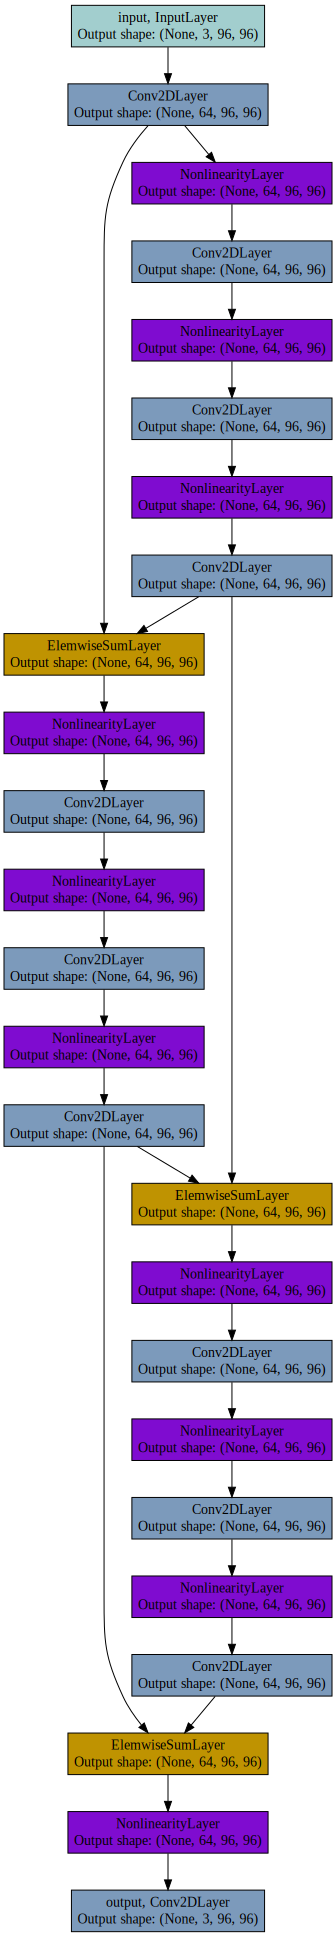

In [6]:
from lasagnekit.misc.draw_net import draw_to_file
from IPython.display import SVG
draw_to_file(layers.get_all_layers(all_layers['output']), 'out.svg')
SVG('out.svg')

In [7]:
train_fn = theano.function([X, Y], loss, updates=params_updates, on_unused_input='warn')

In [8]:
predict_fn = theano.function([X], Y_pred, on_unused_input='warn')

In [9]:
from data import load_data
from lasagnekit.datasets.rescaled import Rescaled
from lasagnekit.easy import iterate_minibatches
from lasagnekit.datasets.imagecollection import ImageCollection
from lasagnekit.datasets.transformed import Transformed
from lasagnekit.datasets.stl import STL
from lasagnekit.datasets.helpers import load_once, split
from lasagnekit.datasets.subsampled import SubSampled

w, h = 96, 96
scale = {1: 96, 2: 96/4}
batch_size = 64

c = 3

data_scale1 = load_once(STL)(kind='unlabeled')
data_scale1.load()

In [10]:
data_scale1_train, data_scale1_test = split(data_scale1, test_size=0.01)

In [11]:
data_scale1_train = SubSampled(data_scale1, batch_size, mode='random')
data_scale2_train = Rescaled(data_scale1_train, (scale[2], scale[2]))
data_scale2_train = Rescaled(data_scale2_train, (scale[1], scale[1]))

In [12]:
data_scale2_test = Rescaled(data_scale1_test, (scale[2], scale[2]))
data_scale2_test = Rescaled(data_scale2_test, (scale[1], scale[1]))

In [13]:
data_scale2_test.load()

In [14]:
def preprocess(x, s=32):
    x = x.reshape((x.shape[0], s, s, c))
    x = x.transpose((0, 3, 1, 2))
    return x

In [15]:
print(all_layers['output'].output_shape)

(None, 3, 96, 96)


In [16]:
from time import time, sleep
a = 0.001
lr.set_value(a)
train_loss = []
test_loss = []
avg_loss = 0

start = time()


In [17]:
a = 0.001
lr.set_value(a)

In [ ]:
for i in range(1000):
    data_scale1_train.load()
    data_scale2_train.load()
    # update parameters based on one minibatch
    X_scale1 = preprocess(data_scale1_train.X, s=scale[1])
    X_scale2 = preprocess(data_scale2_train.X, s=scale[1])
    loss_val = train_fn(X_scale2, X_scale1 - X_scale2)
    avg_loss = 0.9 * avg_loss + 0.1 * loss_val
    train_loss.append(avg_loss)
    
    if i % 100 == 0:
        #a = a * 0.5
        #lr.set_value(a)
        delta = time() - start
        start = time()
        print('Nb of seconds since the last validation step : {}'.format(delta))
        print("computing test performance")
        X_scale1 = preprocess(data_scale1_test.X, s=scale[1])
        X_scale2 = preprocess(data_scale2_test.X, s=scale[1])
        # test the model on test data
        total_loss = 0.
        nb = 0
        for mini_batch in iterate_minibatches(len(X_scale1), batch_size):
            resid = (X_scale1[mini_batch] - X_scale2[mini_batch])
            pred_resid = predict_fn(X_scale2[mini_batch])
            loss_val = ((pred_resid - resid) ** 2).mean()
            total_loss += loss_val
            nb += 1
        total_loss /= nb
        test_loss.append(total_loss)
        print('train_loss : {}, test_loss : {}'.format(train_loss[-1], test_loss[-1]))

Nb of seconds since the last validation step : 4.93647503853
computing test performance
train_loss : 130.340637207, test_loss : 24850.394043

In [ ]:
#plt.plot(train_loss, label='train loss')
print(train_loss)
plt.plot(test_loss, label='test loss')
plt.legend()
#print(test_loss)

In [ ]:
out1 = X_scale2[0:100]
for i in range(1):
    out1 = predict_fn(out1)
#out1 = X_scale1[0:100]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import dispims_color

fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_scale2[0:100].transpose((0, 2, 3, 1)),border=1)
plt.imshow(img, interpolation='none')
plt.savefig('a.png')
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_scale1[0:100].transpose((0, 2, 3, 1)),border=1)
plt.imshow(img, interpolation='none')
plt.savefig('b.png')

fig = plt.figure(figsize=(20, 20))
img = dispims_color((out1[0:100] + X_scale2[0:100]).transpose((0, 2, 3, 1)),border=1)
plt.imshow(img, interpolation='none')
plt.savefig('c.png')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import dispims_color

ss = np.random.uniform(size=(100, c, 32, 32))
ss = ss.astype(np.float32)
for i in range(1):
    ss = predict_fn(ss)
fig = plt.figure(figsize=(10, 10))
img = dispims_color(ss[0:100].transpose((0, 2, 3, 1)),border=1)
plt.axis('off')
plt.imshow(img, interpolation='none')